In [1]:
import pickle

from scipy.stats import norm
from scipy.stats import iqr

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pymbar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
SEED = 428
SIZE = 20

SMC_STEPS = 10000
MET_STEPS = 10000

[mu]
[mu]


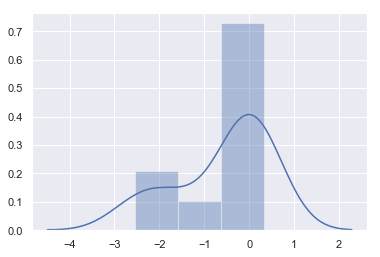

In [3]:
rnd = np.random.RandomState(SEED)
x = rnd.normal(loc=0, scale=1, size=10)
sns.distplot(x)

with pm.Model() as model_1:
    mu = pm.Normal("mu", mu=3, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
print(model_1.vars)

with pm.Model() as model_2:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
print(model_2.vars)

# Sequential Monte Carlo

In [ ]:
with model_1:
    trace_m1 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
pm.traceplot(trace_m1[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_1.marginal_likelihood)))

In [ ]:
with model_2:
    trace_m2 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
pm.traceplot(trace_m2[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_2.marginal_likelihood)) )

In [ ]:
print("Log10 of Bayes factor model 2 over model 1: %0.5f" %(np.log10(model_2.marginal_likelihood) - 
      np.log10(model_1.marginal_likelihood)))

# BAR estimator

In [4]:
def dict_to_list(dict_of_list):
    """
    :param dict_of_list: dict: varname --> ndarray
    :return: list of dic: [ {varname: float, ...}, ...  ]
    """
    keys = list(dict_of_list.keys())
    key0 = keys[0]
    for key in keys[1:]:
        assert len(dict_of_list[key0]) == len(dict_of_list[key]), key0 + " and " + key + " do not have same len."

    n = len(dict_of_list[key0])
    ls_of_dic = []
    for i in range(n):
        dic = {key: dict_of_list[key][i] for key in keys}
        ls_of_dic.append(dic)
    return ls_of_dic


def get_values_from_trace(model, trace, burn=0):
    varnames = [var.name for var in model.vars]
    trace_values = {var: trace.get_values(var, burn=burn) for var in varnames}
    return trace_values

In [5]:
def log_normal_pdf(mu, sigma, y):
    sigma2 = sigma * sigma
    res = - 0.5 * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * (y - mu) ** 2
    return res


def log_normal_trace(trace_val, mu_sigma_dict):
    keys = list(trace_val.keys())
    if len(keys) == 0:
        return 0.
    
    k0 = keys[0]
    for k in keys[1:]:
        assert len(trace_val[k0]) == len(trace_val[k]), k0 + " and " + k + " do not have same len."

    nsamples = len(trace_val[k0])
    logp = np.zeros(nsamples, dtype=float)
    for k in keys:
        mu = mu_sigma_dict[k]["mu"]
        sigma = mu_sigma_dict[k]["sigma"]
        y = trace_val[k]
        logp += log_normal_pdf(mu, sigma, y)

    return logp


def draw_normal_samples(mu_sigma_dict, nsamples, random_state=None):
    rand = np.random.RandomState(random_state)
    keys = mu_sigma_dict.keys()
    samples = {k: rand.normal(loc=mu_sigma_dict[k]["mu"], scale=mu_sigma_dict[k]["sigma"], size=nsamples)
               for k in keys}
    return samples

In [13]:
def log_posterior_trace(model, trace_values):
    model_vars = set([var.name for var in model.vars])
    trace_vars = set(trace_values.keys())
    if model_vars != trace_vars:
        print("model_vars:", model_vars)
        print("trace_vars:", trace_vars)
        raise ValueError("model_vars and trace_vars are not the same set")

    trace_values = dict_to_list(trace_values)
    get_logp = np.vectorize(model.logp)
    logp = get_logp(trace_values)
    return logp

def pot_ener(sample, model):
    u = -log_posterior_trace(model, sample)
    return u


def pot_ener_normal_aug(sample, model, sample_aug, mu_sigma):
    u1 = -log_posterior_trace(model, sample)
    u2 = -log_normal_trace(sample_aug, mu_sigma)
    u = u1 + u2
    return u

In [15]:
def bootstrap_BAR(w_F, w_R, repeats):
    """
    :param w_F: ndarray
    :param w_R: ndarray
    :param repeats: int
    :return: std, float
    """
    n_F = len(w_F)
    n_R = len(w_R)
    delta_Fs = []
    for _ in range(repeats):
        w_F_rand = np.random.choice(w_F, size=n_F, replace=True)
        w_R_rand = np.random.choice(w_R, size=n_R, replace=True)

        df = pymbar.BAR(w_F_rand, w_R_rand, compute_uncertainty=False, relative_tolerance=1e-6, verbose=False)
        delta_Fs.append(df)

    delta_Fs = np.asarray(delta_Fs)
    delta_Fs = delta_Fs[~np.isnan(delta_Fs)]
    delta_Fs = delta_Fs[~np.isinf(delta_Fs)]

    return delta_Fs.std()


def bayes_factor(model_ini, sample_ini, model_fin, sample_fin, aug_mu_sigma, bootstrap=None):
    varnames = list(sample_ini.keys())
    assert varnames == list(sample_fin.keys()), "sample_ini and sample_fin do not have the same keys"
    
    nsamples_ini = len(sample_ini[varnames[0]])
    nsamples_fin = len(sample_fin[varnames[0]])
    
    sample_aug_ini = draw_normal_samples(aug_mu_sigma, nsamples_ini)
    sample_aug_fin = draw_normal_samples(aug_mu_sigma, nsamples_fin)
    
    # potential for sample drawn from i estimated at state i
    u_i_i = pot_ener_normal_aug(sample_ini, model_ini, sample_aug_ini, aug_mu_sigma)
    
    # potential for sample drawn from i estimated at state f
    u_i_f = pot_ener_normal_aug(sample_ini, model_fin, sample_aug_ini, aug_mu_sigma)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener_normal_aug(sample_fin, model_fin, sample_aug_fin, aug_mu_sigma)
    
    # potential for sample drawn from f estimated at state i
    u_f_i = pot_ener_normal_aug(sample_fin, model_ini, sample_aug_fin, aug_mu_sigma)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

# Metropolis MC

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:03<00:00, 6278.27draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a87fb70>,
      dtype=object)

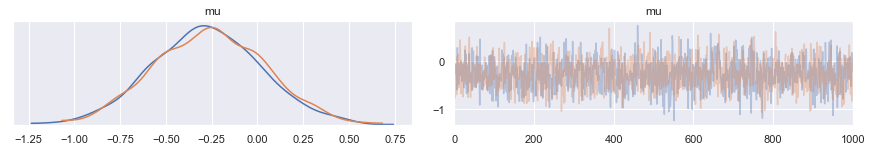

In [9]:
with model_1:
    trace_m1 = pm.sample(SMC_STEPS, step=pm.Metropolis(), random_seed=SEED)
pm.traceplot(trace_m1[::10])

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:03<00:00, 6257.05draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ae126a0>,
      dtype=object)

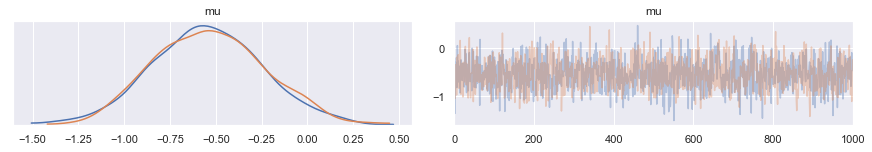

In [10]:
with model_2:
    trace_m2 = pm.sample(SMC_STEPS, step=pm.Metropolis(), random_seed=SEED)
pm.traceplot(trace_m2[::10])

In [11]:
sample_m1 = get_values_from_trace(model_1, trace_m1)
sample_m2 = get_values_from_trace(model_2, trace_m2)

## BAR estimate without augmenting

In [16]:
bayes_factor(model_1, sample_m1, model_2, sample_m2, {}, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =           -5.722
relative_change =        0.000
iteration     1: DeltaF =           -5.722
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 2 iterations (5 function evaluations)
DeltaF =   -5.722
Running 100 bootstraps to estimate error.
log10(bf) = 2.48504 +/- 0.00194


(5.722017886869684, 0.004459721983861338)